# MaBoSS Ecosystem Jupyter Notebook

In [1]:
# Set up working environment
import matplotlib.pyplot as plt
import maboss
import ginsim

This notebook has been executed using the docker image `colomoto/colomoto-docker:2019-07-17`

The original cell fate model (Calzone et al., 2010) was defined to study the cell fate decision process in response to the engagement of the death receptors TNFR and Fas.  Depending to the presence of the corresponding  ligands, several pathways can be activated: survival through NFkB activation, death through necrosis (NonACD), or apoptosis. This model has been extended to account for a documented activation of TNFalpha by NFkB (bold arrow).

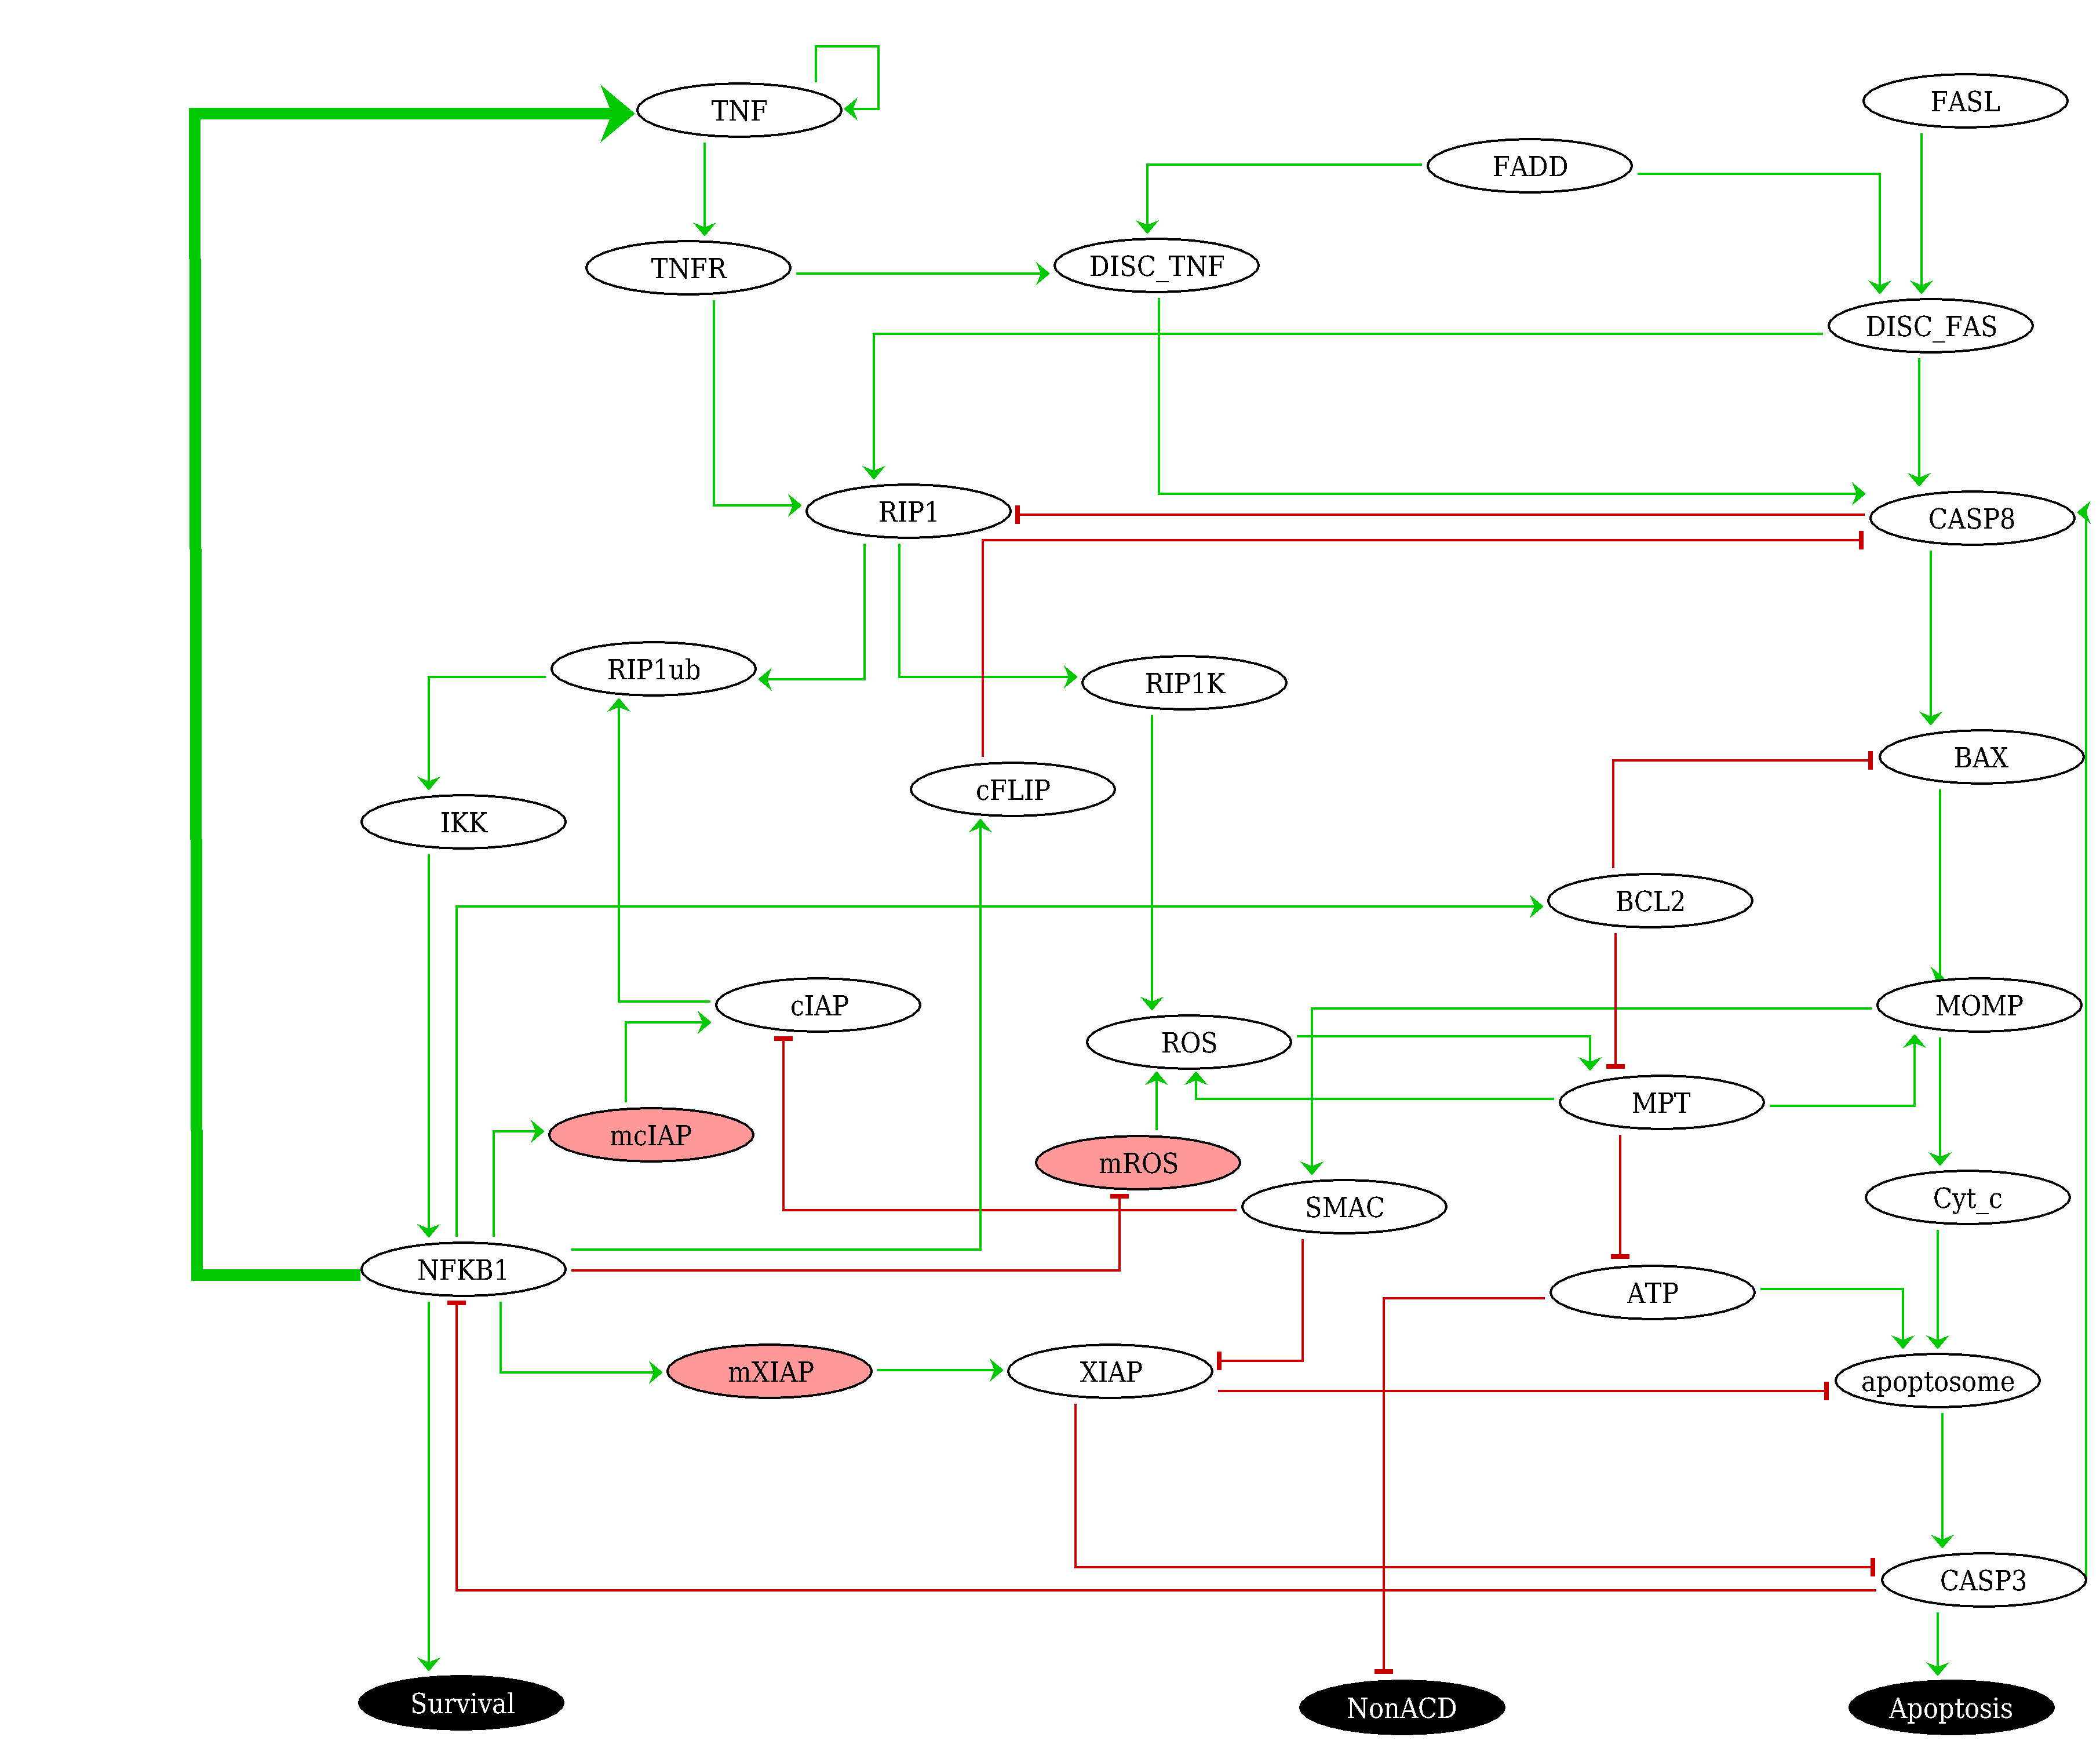

In [2]:
lrg = ginsim.load("models/CellFate_MaBoSS.zginml")
ginsim.show(lrg)

The BND file lists all the logical rules for each of the variables.
The CFG file defines all the parameters for the simulations (transition rates, simulation parameters and initial conditions).
The UPP file informs on the intercellular conditions and population updates.
These files are loaded with the code contained in the following cell.

In [3]:
# Set up the required files
bnd_file = "models/CellFateModel_uppmaboss.bnd"
cfg_WT = "models/CellFateModel_uppmaboss.cfg"
upp_file = "models/CellFateModel_uppmaboss.upp"

# MaBoSS simulation of the wild type model

Note that the variable "Death" monitors death by apoptosis or by non-apoptotic cell death, while the variable "Division" reports the activity of NFkB.

The following command lines load the wildtype model, set the maximal global simulation time to 48 hours, and define the nodes considered in the output:

In [4]:
# Load the Wild-Type model
model_WT = maboss.load(bnd_file, cfg_WT)

# Set some parameters in the cfg file: "max_time" 
model_48h = maboss.copy_and_update_parameters(model_WT, {'max_time':48})

# Set output nodes
model_48h.network.set_output(('NonACD', 'Apoptosis'))


Next, we launch the simulation with the following command lines:

In [5]:
run_48h = model_48h.run()

The result of the simulation can be displayed with the following command line:

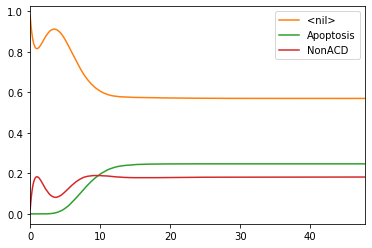

In [6]:
# Plot the results of the WT simulation
run_48h.plot_trajectory()

# Note that the model state <nil> means that none of the external variables are ON. 

### Case 1: no TNF signal, we don't have Death (Apoptosis or NonACD)

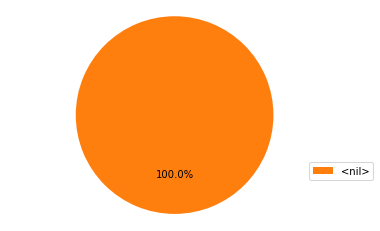

In [7]:
no_tnf_model_48h = model_48h.copy()
no_tnf_model_48h.network.set_istate('TNF', [1, 0])
res_no_tnf = no_tnf_model_48h.run()
res_no_tnf.plot_piechart()

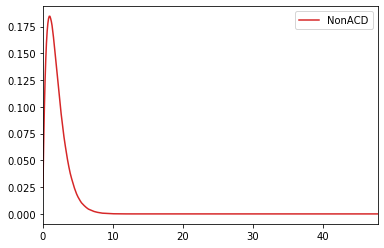

In [8]:
res_no_tnf.plot_node_trajectory()

### Case 2: TNF signal turned on, we get > 40% death (18% NonACD, 25% Apoptosis)

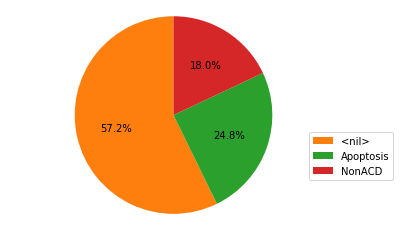

In [9]:
tnf_model_48h = no_tnf_model_48h.copy()
tnf_model_48h.network.set_istate('TNF', [0, 1])
res_tnf = tnf_model_48h.run()
res_tnf.plot_piechart()

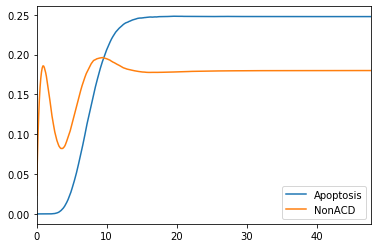

In [10]:
res_tnf.get_nodes_probtraj().plot()

### Case 3: IKK+, cFLIP+ mutant, we don't observe death even with TNF turned on

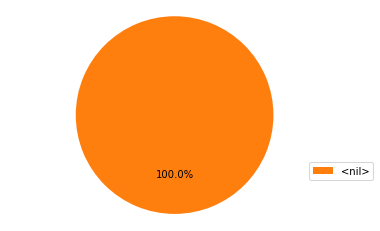

In [11]:
mutant_tnf_model = tnf_model_48h.copy()
mutant_tnf_model.mutate('IKK', 'ON')
mutant_tnf_model.mutate('cFLIP', 'ON')
mutant_res_tnf = mutant_tnf_model.run()
mutant_res_tnf.plot_piechart()

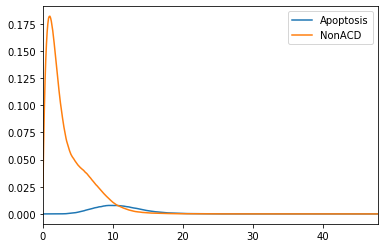

In [12]:
mutant_res_tnf.get_nodes_probtraj().plot()

# UpPMaBoSS simulations

We took the precendent model, and added two output nodes DIVISION and DEATH, as shown in the regulatory graph using GINsim with the following command line. 

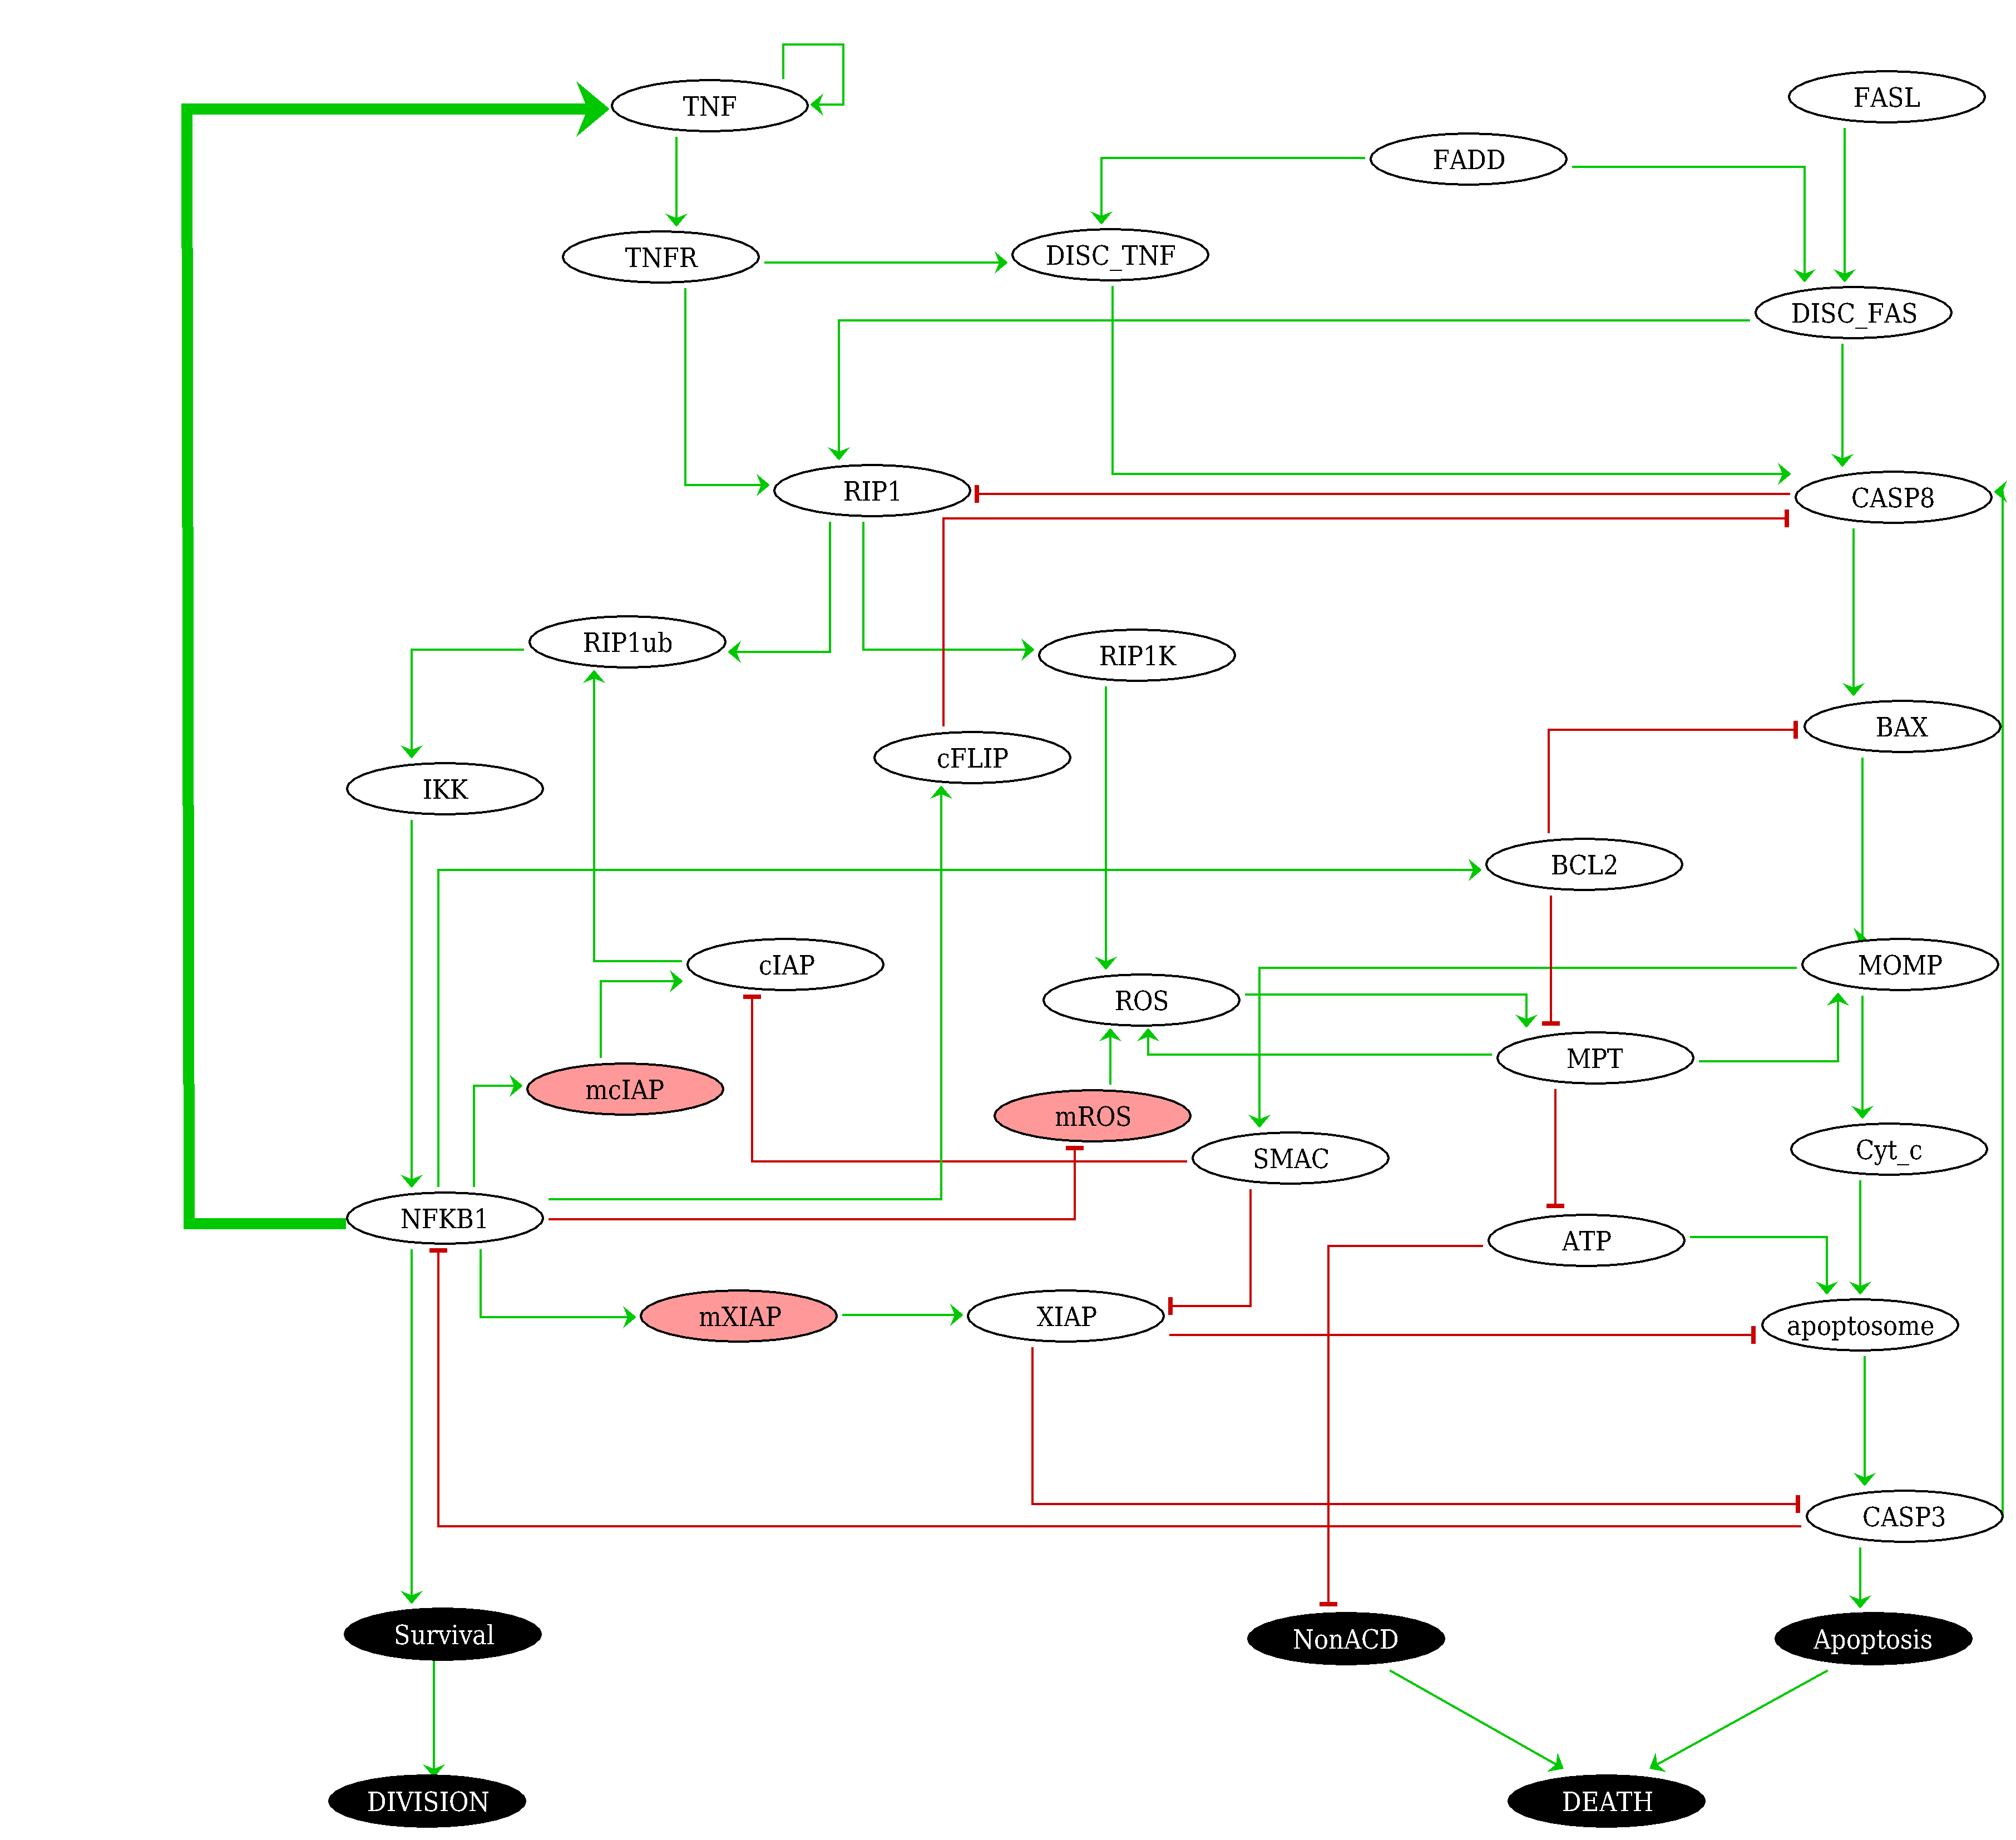

In [13]:
lrg = ginsim.load("models/CellFate_multiscale.zginml")
ginsim.show(lrg)

### Comparison with and without the NFkB - TNF Feedback

In [14]:
# Run UpPMaBoSS on the WT model and collect population ratios
# A folder named "WT" "is created with the 48 runs
uppModel_WT = maboss.UpdatePopulation(model_WT, upp_file)

In [15]:
run_WT = uppModel_WT.run('WT', overwrite=True)
pop_ratios_WT = run_WT.get_population_ratios('NFkB -> TNF')

Next, we create a model variant and launch a 48h UpPMaBoSS simulation for the NoFB model:

In [16]:
# Create a variant without the population feedback NFkB -> TNF
model_NoFB = maboss.copy_and_update_parameters(model_WT, {'$ProdTNF_NFkB': 0})

# Run UpPMaBoSS for the model without population feedback
# A folder named "NoFB" "is created with the 48 runs
uppModel_NoFB = maboss.UpdatePopulation(model_NoFB, upp_file)
run_NoFB = uppModel_NoFB.run('NoFB', overwrite=True)
pop_ratios_NoFB = run_NoFB.get_population_ratios('No NFkB -> TNF')

We can now display the results of the two previous UpPMaBoSS simulation in a single graph with the following command lines:

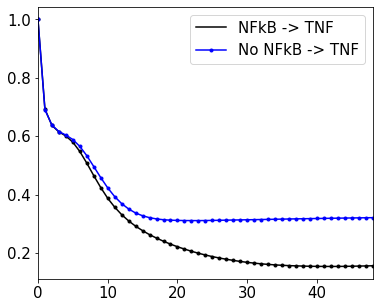

In [17]:
# Plot population ratio with/without population feedback
# A figure is saved in the folder with the name: "figure_ratios.pdf"
figure = plt.figure(figsize = (6,5))
plt.rcParams.update({'legend.fontsize': 15})
pop_ratios_WT.plot(style='.-k', legend=True,fontsize=15)
pop_ratios_NoFB.plot(style='.-b', legend=True)

In this graph, comparing the curves obtained after a pulse of TNF at t = 0 in the absence (blue curve) or in the presence (black curve) of the feedback from NFκB to TNFα, we see that the TNF paracrine loop leads to a significant decrease of the population size.

### Comparative simulations of different TNF treatments

In this section, we simulate the effect of several scenarios for TNF treatments on the wild type cell fate model. 

We first run a simulation for 48 hours without TNF treatment. 

In [18]:
# Create a model with no TNF (TNF OFF)
model_noTNF = model_WT.copy()
model_noTNF.network.set_istate('TNF', [1,0])

# Run UpPMaBoSS for the model with no TNF
# A folder named "noTNF" "is created with the 48 runs
uppModel_noTNF = maboss.UpdatePopulation(model_noTNF, upp_file)
run_noTNF = uppModel_noTNF.run('noTNF')
pop_ratios_noTNF = run_noTNF.get_population_ratios('No pulse TNF')

We then simulate a constant treatment for another 48h on a population of cells that received an initial TNF treatment (reTNF) and compare this simulation with the treatment of a population that was not initially treated with TNF (reTNF_noTNF).

In [19]:
# Create a model for a second treatment of TNF
model_reTNF = maboss.copy_and_update_parameters(model_WT, {'$TNF_induc': 20})

# Run UpPMaBoSS for the second treatment of TNF after a WT run with TNF ON
# A folder named "reTNF" "is created with the 48 runs
uppModel_reTNF = maboss.UpdatePopulation(model_reTNF, upp_file, previous_run=run_WT)
run_reTNF = uppModel_reTNF.run('reTNF')
pop_ratios_reTNF = run_reTNF.get_population_ratios('TNF')

# Run UpPMaBoSS for a treatment of TNF after a run with no TNF (where TNF was initially OFF)
# A folder named "noTNF_reTNF" "is created with the 48 runs
uppModel_noTNF_reTNF = maboss.UpdatePopulation(model_reTNF, upp_file, previous_run=run_noTNF)
run_noTNF_reTNF = uppModel_noTNF_reTNF.run('noTNF_reTNF')
pop_ratios_noTNF_reTNF = run_noTNF_reTNF.get_population_ratios('TNF')

Next, we plot the population ratios computed for the two protocols: 
1. (Pulse of TNF) + TNF (or WT + reTNF), 
2. (no pulse of TNF) + TNF (noTNF + reTNF_noTNF). 

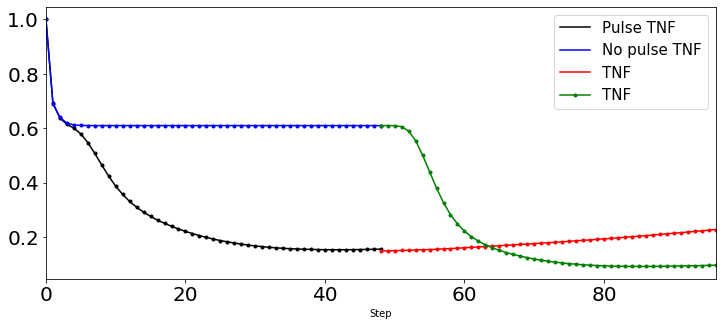

In [20]:
# Plot population ratios for a second treatment of TNF with or without the initial TNF stimulation
# A figure "figure_two_steps_ratios.pdf" is saved
figure = plt.figure(figsize = (12,5))
plt.rcParams.update({'legend.fontsize': 15})
pop_ratios_WT.name = "Pulse TNF"
pop_ratios_WT.plot(style='.-k', legend=True,fontsize=20)
pop_ratios_noTNF.plot(style='.-b', legend=True)
pop_ratios_reTNF.plot(style='.-r', legend=True)
pop_ratios_noTNF_reTNF.plot(style='.-g', legend=True)

# Ensemble models

Using the influence graph, and a list of fixed states as constraints, we built an ensemble of logical models to represent the variability in the logical rules (interaction mechanisms) 

### Simulation with TNF signal ON

In [23]:
ensemble_model_tnf = maboss.Ensemble(
    "./models/ensemble", "models/ensemble_model.cfg",
    outputs=["NonACD", "Apoptosis"],
    istate={"TNF": (0, 1)},
    max_time=48, sample_count=10000,
    individual_results=True,
    random_sampling=True
)

In [24]:
result_tnf = ensemble_model_tnf.run()

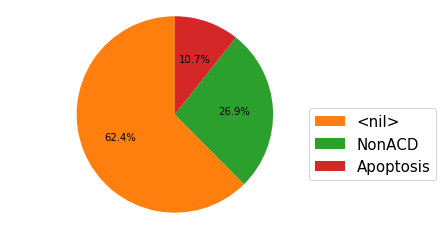

In [25]:
result_tnf.plot_piechart()

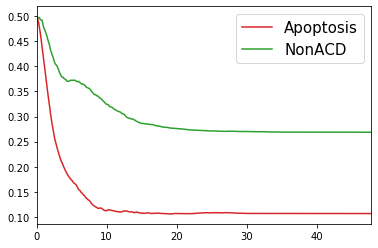

In [26]:
result_tnf.plot_node_trajectory()

### Simulation of the IKK+, cFLIP+ mutant, with TNF signal ON 

In [27]:
ensemble_model_mutant_tnf = maboss.Ensemble(
    "./models/ensemble", "models/ensemble_model.cfg",
    outputs=["NonACD", "Apoptosis"],
    istate={"TNF": (0, 1)},
    mutations={"IKK": "ON", "cFLIP": "ON"},
    max_time=48, sample_count=10000,
    individual_results=True,
    random_sampling=True
)

In [28]:
result_mutant_tnf = ensemble_model_mutant_tnf.run()

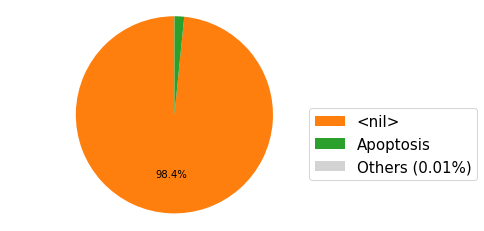

In [29]:
result_mutant_tnf.plot_piechart()

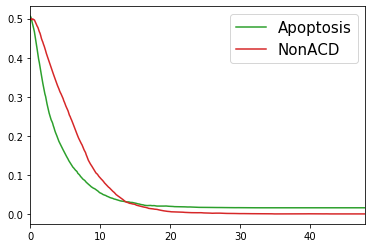

In [30]:
result_mutant_tnf.plot_node_trajectory()